### Proyecto Garch -  Volatilidad Dinámica

Saavedra Pérez Miguel Rodrigo

In [1]:
#Importamos paqueterías
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn, seed
from scipy.optimize import minimize
%config InlineBackend.figure_format = "retina"

In [2]:
#Cargamos información
market=pd.read_excel("Prueba.xlsx", index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "") for c in market.columns]

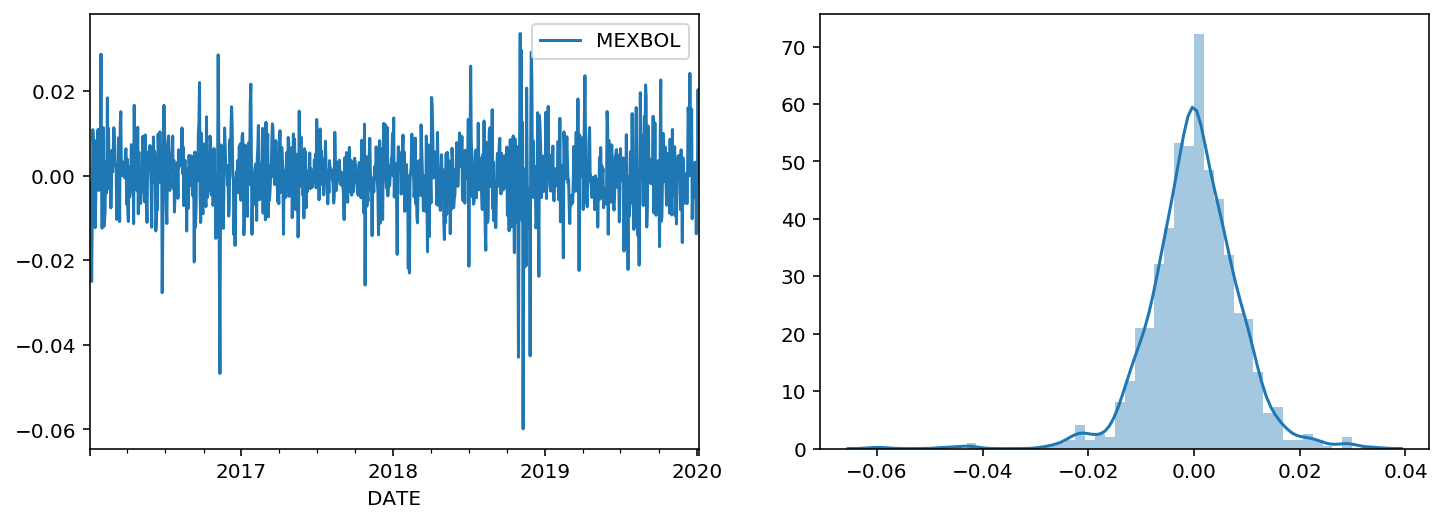

In [3]:
#Graficamos el logaritmo de las diferencias en el tiempo del índice de mercado y su distribución
R = market[["MEXBOL"]]
R = np.log(R).diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
R.plot(ax=ax[0])
sns.distplot(R, ax=ax[1])
plt.show()

In [4]:
#Creamos set de prueba y entrenamiento
test_year = "2019"
R_train = R[:test_year]
R_test = R[test_year:]

$\textbf{Modelaremos mediante Garch}$

$\log L = \sum_{t=1}^T\left(\log \sigma_t^2 + \frac{r_t^2}{\sigma_t^2}\right)$  

Modificaremos el calculo de la volatilidad  
$$
    \sigma_t^2 = \omega + \alpha r^2_{t-1} + \beta\sigma^2_{t-1}
$$

para tener un modelo de volatilidad dinámica
$$
    \sigma_t^2 = (1 - \lambda) r^2_{t-1} + \lambda \sigma_{t-1}^2
$$

In [5]:
#Nueva clase
class GARCHSigmasVolatilidadDinamica:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, sigma_init, lmbda, R):
        self.R = R
        self.lmbda = lmbda
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t - 1
        """
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = (1-self.lmbda)*(rt0**2)+(self.lmbda*sigma0)
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [6]:
class GARCHSigmas:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, omega, alpha, beta, sigma_init, R):
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t - 1
        """
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = self.omega + self.alpha * rt0 ** 2 + self.beta * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [7]:
def LGarchVolatilidadDinamica(sigma_int, lmbda, R):
    s = GARCHSigmasVolatilidadDinamica(sigma_init, lmbda, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel()**2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum()/2
    return log_likelihood
def LGarch(omega, alpha, beta, sigma_init, R):
    s = GARCHSigmas(omega, alpha, beta, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum() / 2
    return log_likelihood

In [13]:
seed(314)

sigma_init = R.var(ddof = 1).item() / 252

lmbda = np.abs(randn(1))
omega, alpha, beta = np.abs(randn(3))

# Configuración del modelo voldatilidad dinámica
x0 = np.array([lmbda])
L_partVolatilidadDinamica = lambda x0: LGarchVolatilidadDinamica(sigma_init, *x0 ,R)

def constraints_1(x):
    return 1 - x[0]

constraints = [{"type": "ineq", "fun":constraints_1},
               {"type": "ineq", "fun":constraints_2}]

fmin_volatilidadDinamica = minimize(L_partVolatilidadDinamica, x0, constraints = constraints)


# Configuración del modelo
x0 = np.array([omega, alpha, beta])
L_part = lambda x0: LGarch(*x0, sigma_init, R)

def cons(x):
    return x[1] + x[2] - 1

# restricción de no negativos
bounds = [
    (0, None),
    (0, None),
    (0, None)
]

fmin = minimize(L_part, x0, constraints={"type": "ineq", "fun": cons}, bounds=bounds)

C:\Users\migro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\migro\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\Users\migro\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\migro\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\migro\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\migro\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value 

In [14]:
fmin_volatilidadDinamica

     fun: -4355.826078640734
     jac: array([0.05291748])
 message: 'Optimization terminated successfully.'
    nfev: 38
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.90886798])

In [15]:
fmin

     fun: -4424.489185943455
     jac: array([5.40677545e+05, 1.26830078e+02, 1.09680481e+02])
 message: 'Positive directional derivative for linesearch'
    nfev: 132
     nit: 26
    njev: 22
  status: 8
 success: False
       x: array([1.82888556e-05, 4.70535723e-01, 5.26574799e-01])

In [16]:
lmbda_garch = fmin_volatilidadDinamica.x
omega_garch, alpha_garch, beta_garch = fmin.x

sigma0 = sigma_init

garch_predict_VolatilidadDinamica = []
for i in range(len(R)):
    sigma0 = (1 - lmbda_garch) * R.iloc[i].item() ** 2 + lmbda_garch * sigma0
    garch_predict_VolatilidadDinamica.append(sigma0)
    
garch_predict = []
for i in range(len(R)):
    sigma0 = omega_garch + alpha_garch * R.iloc[i].item() ** 2 + beta_garch * sigma0
    garch_predict.append(sigma0)

C:\Users\migro\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  
C:\Users\migro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: `item` has been deprecated and will be removed in a future version
  del sys.path[0]


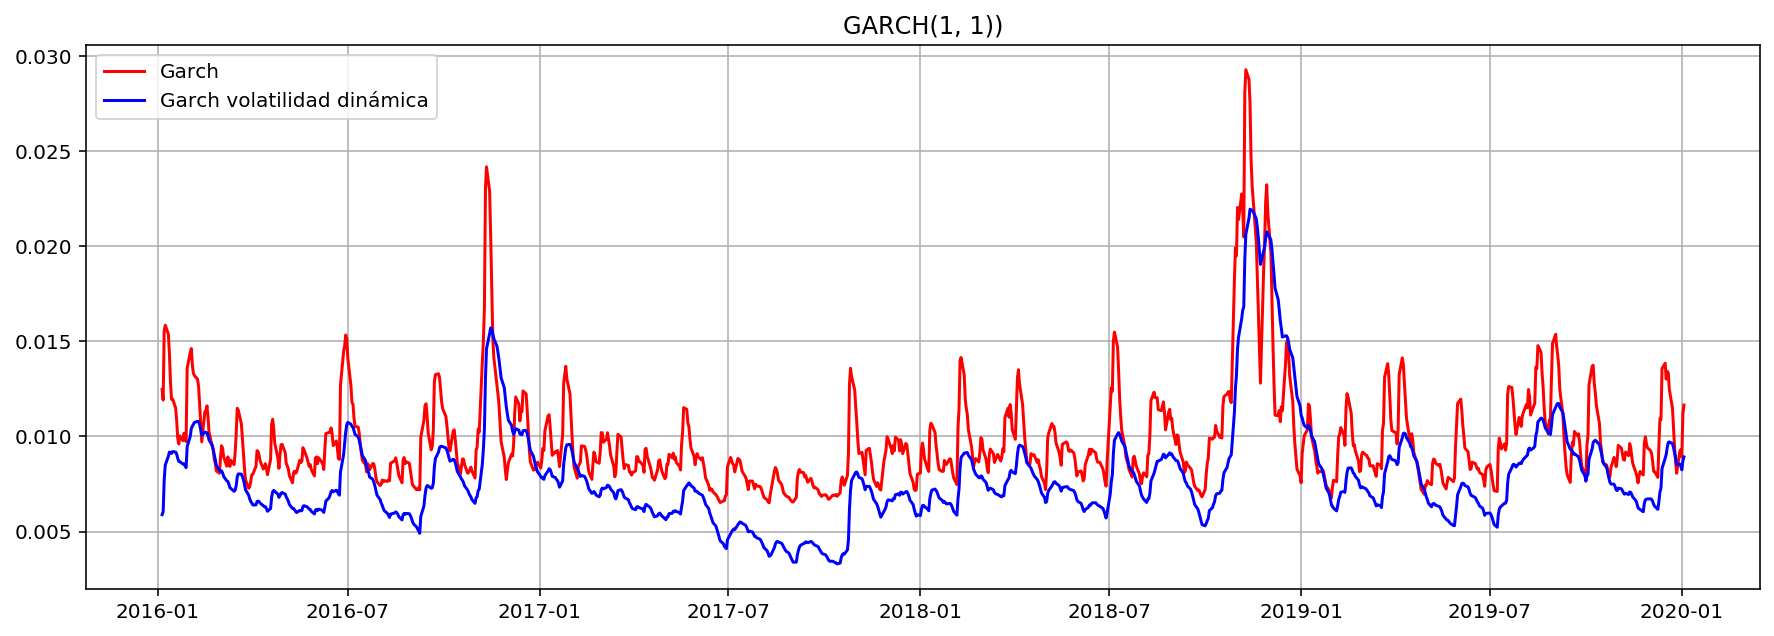

In [17]:
xaxis = R.index[1:]
sigma_garch = pd.DataFrame(np.sqrt(garch_predict)[1:])
sigma_garch_VolatilidadDinamica = pd.DataFrame(np.sqrt(garch_predict_VolatilidadDinamica)[1:])

fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
plt.title("GARCH(1, 1))")
plt.grid()
plt.plot(xaxis, sigma_garch.ewm(2).mean(), c="red", label="Garch");
plt.plot(xaxis, sigma_garch_VolatilidadDinamica.ewm(2).mean(), c="blue", label="Garch volatilidad dinámica")
plt.legend(fontsize=10, loc ='upper left' );